# Method comparison of CCI ranking based on no. of significant LR pairs.
Will focus on pair which is highly ranked in the other methods but low-
ranked by stLearn as example, and show the squidpy colocalisation
analysis of the two cell types.

##### INPUT: 
   * data/breast/cci_summary.txt
   * data/breast/singlecellsignalr/scsignalr_summary.txt
   * data/breast/natmi/natmi_cci_summary.txt
   * data/breast/squidpy/squidpy_cci_summary.txt
   * data/breast/cellphonedb/cpdb_cci_summary.txt
  
##### OUTPUT: 
   * plots/X1_method_comp/
   
## Environment Setup

In [6]:
#TODO: NOTE must be run in directory: /
work_dir = '/Users/uqbbalde/Desktop/Uni_Studies/projects/stlearn_manuscript/' \
           'mainfigCCI_newCCISupps/' # TODO update this with your path

import os, sys
os.chdir(work_dir)

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import stlearn as st
import squidpy as sq

import importlib

import scripts.utils.visualisation.helpers as vhs
import scripts.utils.visualisation.quick_plots as qpl

import stlearn.plotting.cci_plot_helpers as cci_hs

import scripts.utils.multi_comp_helpers as mch

data_dir = 'data/breast/'
data_dir2 = '/Volumes/GML001-Q1851/Brad/'
data_dir3 = 'data/breast/singlecellsignalr/'
data_dir4 = 'data/breast/natmi/'
data_dir5 = 'data/breast/squidpy/'
data_dir6 = 'data/breast/cellphonedb/'
out_plots = 'plots/X1_method_comp/'

out = '.pdf'

## Loading the data

In [3]:
#### Also loading the LR features to look for expression level bias in CellChat
data = sc.read_h5ad(data_dir2+'breast_LR&CCIResults.h5ad')
lrfeatures = data.uns['lrfeatures']

cci_summary = pd.read_csv(data_dir+'cci_summary.txt', sep='\t')
# Subsetting to cci_rank tested #
cci_summary = cci_summary.loc[cci_summary.loc[:,'cci_tested'], :]

#### Loading the other methods ran ######
signalr_summary = pd.read_csv(data_dir3+'scsignalr_summary.txt', sep='\t')
natmi_summary = pd.read_csv(data_dir4+'natmi_cci_summary.txt',
                            sep='\t', index_col=0)
squidpy_summary = pd.read_csv(data_dir5+'squidpy_cci_summary.txt',
                            sep='\t', index_col=0)
cpdb_summary = pd.read_csv(data_dir6+'cpdb_cci_summary.txt',
                            sep='\t', index_col=0)

### merging #####
methods = ['', '_NATMI', '_cellchat', '_scsignalr', '_squidpy', '_cpdb']
method_colors = ['gold', 'hotpink', 'darkcyan', 'limegreen', 'mediumpurple',
                 'rosybrown']
# cci_summary = pd.concat([cci_summary, signalr_summary,
#                          natmi_summary, squidpy_summary, cpdb_summary], axis=1)
# Can't put all into single DF due to inconsistent LRs, instead will convert to
# cci as the observations below...
cc_cols = [col for col in cci_summary.columns if 'cellchat' in col]
st_cols = [col for col in cci_summary.columns if 'cellchat' not in col]
st_summary = cci_summary.loc[:,st_cols]
cc_summary = cci_summary.loc[:,cc_cols]
summaries = [st_summary, natmi_summary, cc_summary, signalr_summary,
                                                  squidpy_summary, cpdb_summary]

## Plotting the CCIs ranked by no. of LRs significant

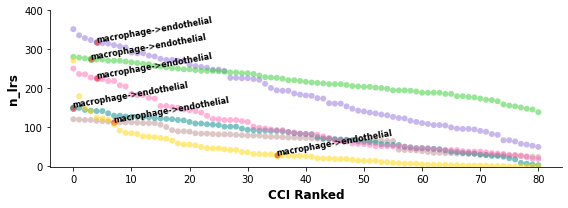

In [4]:
label_set = np.unique(data.obs['cell_type'].values)
cci_set = []
for labeli in label_set:
    for labelj in label_set:
        cci_set.append(f'{labeli}->{labelj}')
cci_set = np.unique(cci_set)

#### Counting the no. of LRs per CCI ######
method_ccis_ranked = []
method_nlrs_ranked = []
method_ccilrs_ranked = []
for i in range(len(methods)):
    ccis_ranked, cci_nlrs_ranked, cci_lrs_ranked = \
                       mch.get_cci_nlr_ranked(cci_set, summaries[i], methods[i])
    method_ccis_ranked.append( ccis_ranked )
    method_nlrs_ranked.append( cci_nlrs_ranked )
    method_ccilrs_ranked.append( cci_lrs_ranked )

# Finding an CCI which has the highest rank by the other methods but
# lowest in stLearn.
perfect = np.array([len(cci_set)] + [0] * (len(methods) - 1))
cand_ccis = mch.get_cands(perfect, cci_set, methods,
                          method_ccis_ranked, method_nlrs_ranked)

###### Plotting the ranked lists - global view ######
int_cci = cand_ccis[0]
highlight_lrs = [int_cci]
rot = 10
fig, ax = plt.subplots(figsize=(8,3))
for method in methods[::-1]:
    i = np.where(np.array(methods)==method)[0][0]
    ccis_ranked, nlrs_ranked = method_ccis_ranked[i], method_nlrs_ranked[i]
    cci_hs.rank_scatter(ccis_ranked, nlrs_ranked, rot=rot,
                        x_label='CCI Ranked', y_label='n_lrs',
                        color=method_colors[i], ax=ax,
                        highlight_items=highlight_lrs, show_text=True,
                        show=False)
ylims = ax.get_ylim()
ax.set_ylim((-1, 400))
vhs.dealWithPlot(True, True, True,
                 out_plots, f'multicomp_breast_cci_ranked{out}', 300)

## Getting candidate example CCI & LR

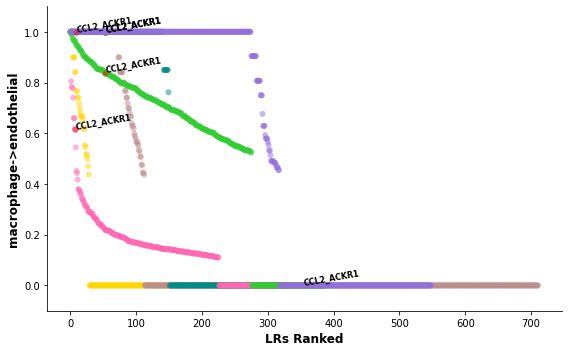

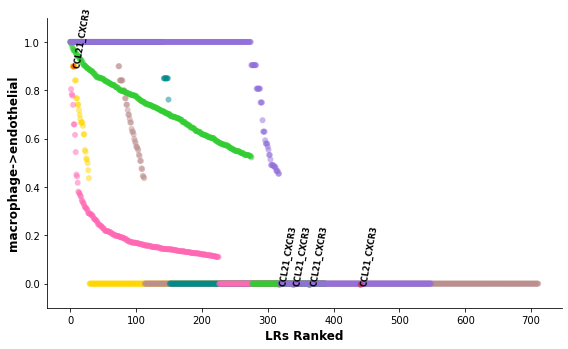

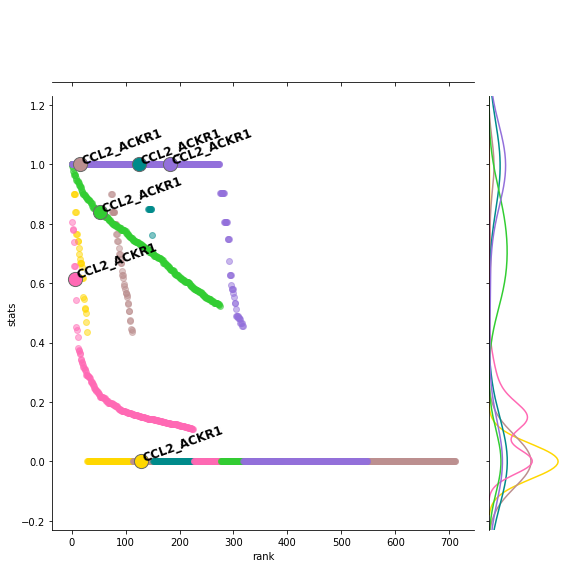

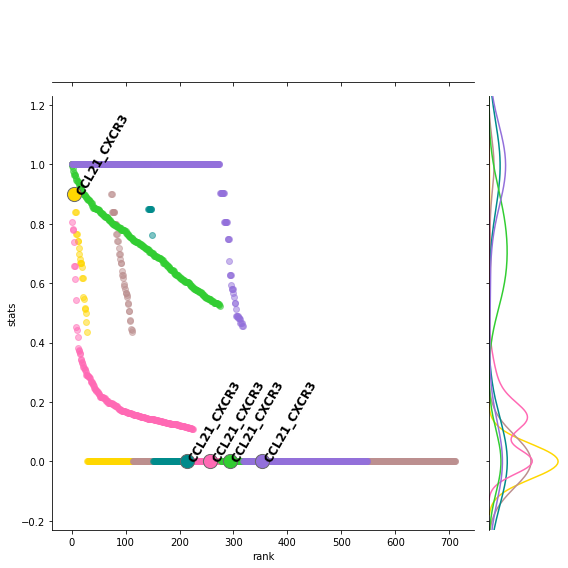

In [7]:
#### Getting the LRs which are called sig for CCI of interest each method ####
int_lrs = []
int_lr_stat = []
for i, method in enumerate(methods):
    summary = summaries[i]
    # Getting the LRs predicted to interact interesting cell types #
    int_cci_loc = np.where(method_ccis_ranked[i]==int_cci)[0][0]
    method_int_cci_lrs = method_ccilrs_ranked[i][int_cci_loc].split(',')
    remaining_lrs = [lr for lr in summary.index.values
                     if lr not in method_int_cci_lrs]
    method_lrs = np.array( method_int_cci_lrs+remaining_lrs )

    # Getting the sig scores for the lr cci method #
    lr_stats = []
    for j, lr in enumerate(method_int_cci_lrs):
        lr_ccis = np.array(summary.loc[lr,f'ccis{method}'].replace(
                                                         '--', '->').split(','))
        lr_cci_loc = np.where(lr_ccis == int_cci)[0][0]
        lr_cci_stat = float(np.array(summary.loc[lr,
                                         f'ps{method}'].split(','))[lr_cci_loc])
        lr_stats.append( lr_cci_stat )
    lr_stats = np.array( lr_stats + [0]*len(remaining_lrs) )

    # Min-max scaling #
    min_, max_ = min(lr_stats), max(lr_stats)
    stats_scaled = (lr_stats-min_) / (max_ - min_)

    # Ordering and saving #
    order = np.argsort(-stats_scaled)
    method_lrs_ordered = method_lrs[order]
    method_lr_stats_ordered = stats_scaled[order]
    int_lrs.append( method_lrs_ordered )
    int_lr_stat.append( method_lr_stats_ordered )

# Finding an CCI which has the highest rank by the other methods but
# lowest in stLearn.
lr_set = cci_summary.index.values.astype(str)
perfect_low = np.array( [cci_summary.shape[0]] + [0]*(len(methods)-1) )
perfect_high = np.array( [0] + [cci_summary.shape[0]]*(len(methods)-1) )
stlow_cands = mch.get_cands(perfect_low, lr_set, methods, int_lrs, int_lr_stat)
sthigh_cands = mch.get_cands(perfect_high, lr_set, methods, int_lrs, int_lr_stat)

#### Plot order will be inverse of when methods go to 0 #####
zero_index = np.array([np.where(int_lr_stat_i==0)[0][0]
                       for int_lr_stat_i in int_lr_stat])
method_order = np.argsort(-zero_index)

methods_ordered = [methods[i] for i in method_order]
int_lrs_ordered = [int_lrs[i] for i in method_order]
int_lr_stat_ordered = [int_lr_stat[i] for i in method_order]
method_colors_ordered = [method_colors[i] for i in method_order]

###### Plotting the ranked lists of LRs for biggest diff CCI - global view ######
figsize = (8,5)

low_lr = stlow_cands[0]
highlight_lrs = [low_lr]
rot = 10
fig, ax = mch.plot_ranked(rot,
                          methods_ordered, int_lrs_ordered, int_lr_stat_ordered,
                'LRs Ranked', f'{int_cci}',method_colors_ordered, highlight_lrs,
                          figsize=figsize)
ylims = ax.get_ylim()
ax.set_ylim((-.1, 1.1))
vhs.dealWithPlot(True, True, True,
               out_plots, f'multicomp_breast_low-lr_{int_cci}_ranked{out}', 300)

##### Now for the high_lr for stlearn ######
high_lr = sthigh_cands[0]
highlight_lrs = [ high_lr ] #[high_lr]
rot = 80
fig, ax = mch.plot_ranked(rot, methods_ordered, int_lrs_ordered,
                          int_lr_stat_ordered,
                'LRs Ranked', f'{int_cci}', method_colors_ordered, highlight_lrs,
                          figsize=figsize)
ylims = ax.get_ylim()
ax.set_ylim((-.1, 1.1))
vhs.dealWithPlot(True, True, True,
               out_plots, f'multicomp_breast_high-lr_{int_cci}_ranked{out}', 300)

####### Trying to plot ranked with histograms on either side of axies ##########
importlib.reload(mch)
low_lr = stlow_cands[0]
highlight_lr = low_lr
method_map = {'': 'stLearn', '_NATMI': 'NATMI', '_cellchat': 'CellChat',
                  '_scsignalr': 'scSignalR', '_squidpy': 'Squidpy',
              '_cpdb': 'CellPhoneDB'}
color_dict_ = {'stLearn': 'gold', 'NATMI': 'hotpink', 'CellChat': 'darkcyan',
                  'scSignalR': 'limegreen', 'Squidpy': 'mediumpurple',
               'CellPhoneDB': 'rosybrown'}
mch.plot_ranked_wHists(int_lrs_ordered[::-1],
                       int_lr_stat_ordered[::-1], methods_ordered[::-1],
                         highlight_lr, method_map, color_dict_, height=8, rot=20)
vhs.dealWithPlot(True, True, True,
         out_plots, f'multicomp_breast_high-lr_{int_cci}_rankedwHist{out}', 300)

high_lr = sthigh_cands[0]
mch.plot_ranked_wHists(int_lrs_ordered[::-1],
                       int_lr_stat_ordered[::-1], methods_ordered[::-1],
                       high_lr, method_map, color_dict_, height=8, rot=60)
vhs.dealWithPlot(True, True, True, out_plots,
                     f'multicomp_breast_low-lr_{int_cci}_rankedwHist{out}', 300)

## Using squidpy, looking at the spatial enrichment between the example sender cell & receiver cell and most significant LR from each method.

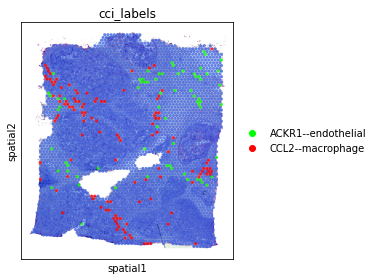

1.4371388


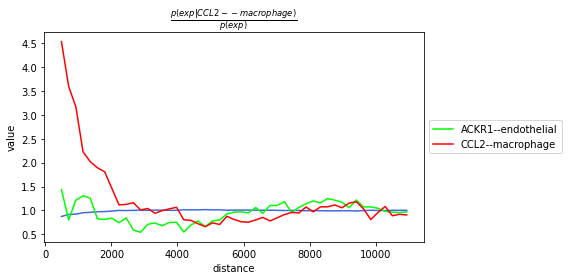

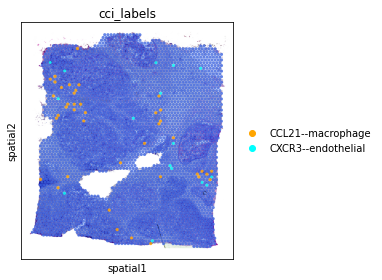

3.5628283


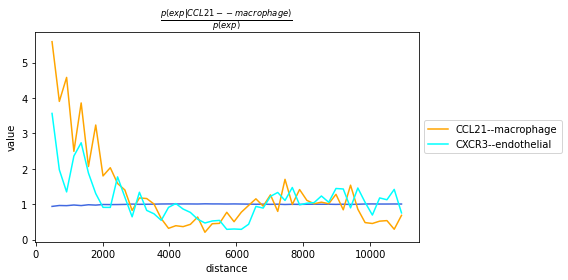

In [8]:
##### For the stlow lr #####
l, r = low_lr.split('_')
sender, target = int_cci.split('->')
colors = ['royalblue', 'lime', 'red']
mch.plot_cci(int_cci, low_lr, data, colors)
vhs.dealWithPlot(True, True, True, out_plots,
                 f'breast_stlow-labels_spatial.pdf', 300)

# Performing squidpy enrichment
sq.gr.co_occurrence(data, cluster_key="cci_labels")
sq.pl.co_occurrence(data,
    cluster_key="cci_labels",
    clusters=f'{l}--{sender}',
    figsize=(8, 4),
)
# Getting the max point.. #
label_set = data.obs['cci_labels'].cat.categories.values.astype(str)
i_loc = np.where(label_set == f'{l}--{sender}')[0][0]
j_loc = np.where(label_set == f'{r}--{target}')[0][0]
max_loc = np.argmax(data.uns['cci_labels_co_occurrence']['occ'][i_loc,j_loc,:])
max_val = max(data.uns['cci_labels_co_occurrence']['occ'][2,1,:])
max_dist = data.uns['cci_labels_co_occurrence']['interval'][max_loc]
print(max_val) # 1.4371388
vhs.dealWithPlot(True, True, True, out_plots,
                 f'breast_stlow_co-occurrence.pdf', 300)

###### For the sthigh LR ######
colors = ['royalblue', 'orange', 'aqua', ]
l, r = high_lr.split('_')
mch.plot_cci(int_cci, high_lr, data, colors, sig=False)
vhs.dealWithPlot(True, True, True, out_plots,
                 f'breast_sthigh-labels_spatial.pdf', 300)
sq.gr.co_occurrence(data, cluster_key="cci_labels")
sq.pl.co_occurrence(data,
    cluster_key="cci_labels",
    clusters=f'{l}--{sender}',
    figsize=(8, 4),
)
# Getting the max point.. #
label_set = data.obs['cci_labels'].cat.categories.values.astype(str)
i_loc = np.where(label_set == f'{l}--{sender}')[0][0]
j_loc = np.where(label_set == f'{r}--{target}')[0][0]
max_loc = np.argmax(data.uns['cci_labels_co_occurrence']['occ'][i_loc,j_loc,:])
max_val = max(data.uns['cci_labels_co_occurrence']['occ'][2,1,:])
max_dist = data.uns['cci_labels_co_occurrence']['interval'][max_loc]
print(max_val) # 3.5628283
vhs.dealWithPlot(True, True, True, out_plots,
                 f'breast_sthigh_co-occurrence.pdf', 300)